In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn import neighbors
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis



In [248]:
df = pd.read_csv("kidney_disease.csv")
df.head(10)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
5,5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,...,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,...,36,NaN,NaN,no,no,no,good,no,no,ckd
7,7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,...,44,6900,5,no,yes,no,good,yes,no,ckd
8,8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,...,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


## 1. Classification Problem

We would like to use supervised machine learning to predict chronic kidney disease, as well as understand which variables help with the diagnosis of it.

## 2. Variable Transformation

In [249]:
df.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [250]:
df['sg'] = pd.Categorical(df['sg'])
df['al'] = pd.Categorical(df['al'])
df['su'] = pd.Categorical(df['su'])


pcv, wc and rc should actually be labeled as float64 and int64 variables. We will not transform them just yet as they only appear as objects because of N/A values. Later, in this analysis, we will drop the N/A values. Some of the variables that are labeled as float64 (continuous) should actually be labeled as int64 (integers), however, this will not make a difference in our calculations (for example, 4 equivalent to 4.0).

## 3. Dataset Overview

In [251]:
df.describe()

,id,age,bp,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


This dataset consists of 400 observations (we may define this as 400 individuals). The youngest individual in this is 2 years old, and the oldest is 90 years old. The average age of the individuals we are looking at is 51 years old. As seen in part 2, there is a fairly even balance between binary (object) and numerical (integer and float variables) variables in this dataset. The average sodium of all individuals has been found as an exact value of 137.528753 milliequivalents per litre, with a standard deviation of 10.408752.

## 4. Association Between Variables

In [252]:
df_numeric = df.select_dtypes(include=['float64'])
df_category = df.select_dtypes(include=['category'])
df_numcat = pd.concat([df_numeric, df_category], axis=1).reindex(df_numeric.index)
df_numcat.corr()


,age,bp,bgr,bu,sc,sod,pot,hemo,sg,al,su
age,1.000000,0.159480,0.244992,0.196985,0.132531,-0.100046,0.058377,-0.192928,-0.191096,0.122091,0.220866
bp,0.159480,1.000000,0.160193,0.188517,0.146222,-0.116422,0.075151,-0.306540,-0.218836,0.160689,0.222576
bgr,0.244992,0.160193,1.000000,0.143322,0.114875,-0.267848,0.066966,-0.306189,-0.374710,0.379464,0.717827
bu,0.196985,0.188517,0.143322,1.000000,0.586368,-0.323054,0.357049,-0.610360,-0.314295,0.453528,0.168583
sc,0.132531,0.146222,0.114875,0.586368,1.000000,-0.690158,0.326107,-0.401670,-0.361473,0.399198,0.223244
sod,-0.100046,-0.116422,-0.267848,-0.323054,-0.690158,1.000000,0.097887,0.365183,0.412190,-0.459896,-0.131776
pot,0.058377,0.075151,0.066966,0.357049,0.326107,0.097887,1.000000,-0.133746,-0.072787,0.129038,0.219450
hemo,-0.192928,-0.306540,-0.306189,-0.610360,-0.401670,0.365183,-0.133746,1.000000,0.602582,-0.634632,-0.224775
sg,-0.191096,-0.218836,-0.374710,-0.314295,-0.361473,0.412190,-0.072787,0.602582,1.000000,-0.469760,-0.296234
al,0.122091,0.160689,0.379464,0.453528,0.399198,-0.459896,0.129038,-0.634632,-0.469760,1.000000,0.269305


The strong associations exist between serum creatinene and sodium, as well as between hemoglobin and blood urea. We see an even stronger association between sugar and blood glucose random. Hemoglibin also has fairly strong associations with albumin and specific gravity. We see that age and bp have weak associations with other variables, however, it is still really important to consider these variables in this particular analysis because increasing age and high blood pressure can definitely correlate with kidney disorders.

Because of the strong associations, our feature selection and extraction must incorporate hemoglobin because of it's relationship with multiple variables. Sodium, serum creatinene, age, blood pressure and blood urea are other variables we can use (we mentioned that sugar and blood glucose random have a strong association, however, their association with other variables is weak.). These variables will help us predict whether or not one has chronic kidney disease.

In [253]:
x = df_numcat[['age','hemo', 'sod', 'sc', 'bu', 'bp']]
y = df['classification']

## 5. Missing Value Analysis

In [254]:
x.isnull().head(10)

,age,hemo,sod,sc,bu,bp
0,False,False,True,False,False,False
1,False,False,True,False,False,False
2,False,False,True,False,False,False
3,False,False,False,False,False,False
4,False,False,True,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False
7,False,False,True,False,False,True
8,False,False,True,False,False,False
9,False,False,False,False,False,False


"True" indicates missing values. Being able to identify these entries confirms to us that we have missing values.

We will not drop any missing values because that will reduce our row numbers for some columns. When it comes to splitting the data for the training and testing stage, we will need to have a consistent number of rows between our predictor and response variables. For our response variable y, we have 400 observations. Hence, for x, we need to keep 400 observations. 

We can replace NA values in each column with the mean value for that column. NA values may give us problems in our classifications, so a good substitute for them would be average values.

In [255]:
x['hemo'].fillna(x['hemo'].mean(), inplace = True)
x['sod'].fillna(x['sod'].mean(), inplace = True)
x['sc'].fillna(x['sc'].mean(), inplace = True)
x['bu'].fillna(x['bu'].mean(), inplace = True)
x['bp'].fillna(x['bp'].mean(), inplace = True)
x['age'].fillna(x['age'].mean(), inplace = True)

/var/folders/z6/4k03kssx2hsf7f1vh9g6w4gm0000gn/T/ipykernel_10313/3576398067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['hemo'].fillna(x['hemo'].mean(), inplace = True)
/var/folders/z6/4k03kssx2hsf7f1vh9g6w4gm0000gn/T/ipykernel_10313/3576398067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sod'].fillna(x['sod'].mean(), inplace = True)
/var/folders/z6/4k03kssx2hsf7f1vh9g6w4gm0000gn/T/ipykernel_10313/3576398067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

## 6. Outlier Analysis

We can use interquartile range to identify outlier values. Values falling outside of this interval,(Q1-1.5xIQR, 
Q3+1.5xIQR), are cosidered outliers. However, it is not important to identify these values as we will not be removing them. We will not be removing them because outliers can sometimes have an influence. In some cases, the removal of outliers can lead to potential bias as it decreases the number of observations being analysed. 

## 7. Sub-Group Analysis

In [256]:
X_std = scale(x)
x=pd.DataFrame(X_std,columns = x.columns)

In [257]:
km = KMeans(n_clusters=4)
y_label = km.fit_predict(x)
x_values = np.array(x)
x_values

array([[-0.20546364,  1.0592712 ,  0.        , -0.33374323, -0.43526769,
         0.26233836],
       [-2.62380991, -0.45209695,  0.        , -0.40503858, -0.80094118,
        -1.96658024],
       [ 0.62031314, -1.07876179,  0.        , -0.2268002 , -0.0899094 ,
         0.26233836],
       ...,
       [-2.32888964,  1.20672175, -0.05751852, -0.44068626, -0.63841963,
         0.26233836],
       [-2.03396936,  0.61691955, -0.27508101, -0.3693909 , -0.15085498,
        -1.22360737],
       [ 0.38437691,  1.20672175,  0.37760647, -0.35156706, -0.80094118,
         0.26233836]])

Text(0.5, 1.0, 'K-Means Clustering')

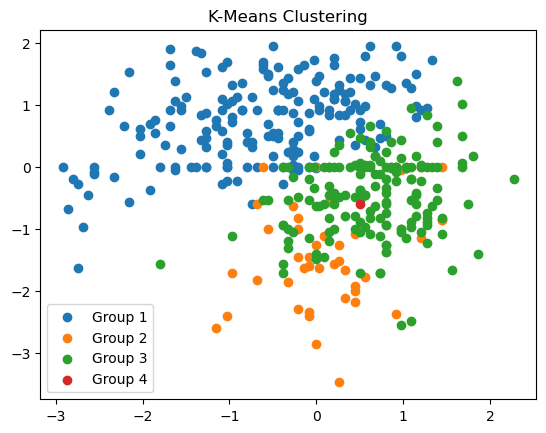

In [258]:
plt.scatter(x_values[y_label == 0,0], x_values[y_label == 0,1], label = "Group 1")
plt.scatter(x_values[y_label == 1,0], x_values[y_label == 1,1], label = "Group 2")
plt.scatter(x_values[y_label == 2,0], x_values[y_label == 2,1], label = "Group 3")
plt.scatter(x_values[y_label == 3,0], x_values[y_label == 3,1], label = "Group 4")
plt.legend()
plt.title("K-Means Clustering")


## 8. Data Splitting

In [259]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=1, stratify=y)

## 9. Classifier Choices

We will use the Decision Tree classifier, as well as the KNN classifier.

Decision Tree classifications are very useful for these types of scenerios. When predicting whether or not someone has chronic kidney disease, the final results might be "yes" (has ckd) or "no" (does not have ckd). Decision Tree's are extremely clear for this as they will set a path with conditions to decide whther or not someone has ckd. In general, having a decision tree is very useful for classification when the target variable is binary (in our case, the "classification" variable is a binary object.).

KNN classifications are something we will use mainly because of their simplicity and high accuracy. These are the main reasons as to why we would like to use KNN algorithms for our classication problem. From part 4, where we obtained all the correlations between the numeric variables in the dataset, we were able to extract relevent predictor variables for our classification problem. Using KNN modeling, these variables can help predict whether or not someone has chronic kidney disease with high accuracy.

## 10. Performance Metrics

We will use accuracy scores and confusion matrices to compare our models. In terms of accuracy, the model with the higher accuracy score will be better. When looking at a confusion matrices, we should be seeing that our predicted values are fairly close to the actual values.

## 11 & 12. Classifier Comparision

### KNN Classification

In [260]:
knn = neighbors.KNeighborsClassifier()

In [261]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [262]:
prediction1 = knn.predict(X_test)
print("Accuracy Score:", round(metrics.accuracy_score(y_test, prediction1),5))

Accuracy Score: 0.90833


In [263]:
confusion_matrix(y_test, prediction1)

array([[71,  0,  3],
       [ 1,  0,  0],
       [ 7,  0, 38]])

Text(0.5, 1.0, 'KNN Classifier Confusion Matrix')

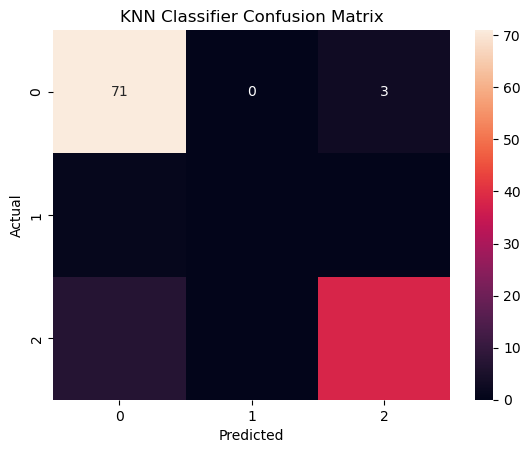

In [264]:
sns.heatmap(confusion_matrix(y_test, prediction1), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("KNN Classifier Confusion Matrix")

### Decision Tree Classifier

In [265]:
dt = DecisionTreeClassifier()


In [266]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [267]:
prediction2 = dt.predict(X_test)
print("Accuracy Score:", round(metrics.accuracy_score(y_test, prediction2),5))

Accuracy Score: 0.91667


In [268]:
confusion_matrix(y_test, prediction2)

array([[73,  0,  1],
       [ 1,  0,  0],
       [ 8,  0, 37]])

Text(0.5, 1.0, 'Decsion Tree Classification Confusion Matrix')

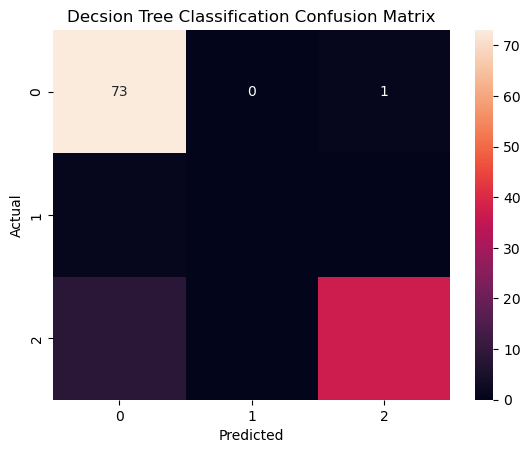

In [269]:
sns.heatmap(confusion_matrix(y_test, prediction2), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Decsion Tree Classification Confusion Matrix")

When comparing the classifiers based on the test set, we can see the the decision tree has the higher accuracy score, meaning that this classifier is better in terms of accuracy.

Looking at the 3x3 confusion matrices, the (0,0) coordinate (top-left) represents our true positives. Coordinates (0,1) and (0,2) represent false positives. Coordinates (1,0) and (2,0) represent false negatives. The remaining coordinates are true negatives. We would look for high true positve & negative values, and low false positive & negative values. Based on this criteria, both models are equally good (Decision tree does have higher true positve value, but also lower true negative values. Decision Tree does have lower false negatives, but higher false positives.) when evaluating confusion matrices.

Based on both of these performance metrics, we will conclude that Decision Tree is the better classifier, as it has a higher accuracy score.

## 13. Interpretable Classifier Insight

[Text(0.5795454545454546, 0.9375, 'X[1] <= 0.23\ngini = 0.473\nsamples = 280\nvalue = [174, 1, 105]'),
 Text(0.38636363636363635, 0.8125, 'X[2] <= 0.704\ngini = 0.08\nsamples = 168\nvalue = [161, 1, 6]'),
 Text(0.2727272727272727, 0.6875, 'X[1] <= 0.156\ngini = 0.048\nsamples = 162\nvalue = [158, 1, 3]'),
 Text(0.18181818181818182, 0.5625, 'X[4] <= -0.811\ngini = 0.025\nsamples = 156\nvalue = [154, 1, 1]'),
 Text(0.13636363636363635, 0.4375, 'X[2] <= -0.138\ngini = 0.56\nsamples = 5\nvalue = [3, 1, 1]'),
 Text(0.09090909090909091, 0.3125, 'X[4] <= -0.842\ngini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(0.045454545454545456, 0.1875, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.13636363636363635, 0.1875, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.18181818181818182, 0.3125, 'gini = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(0.22727272727272727, 0.4375, 'gini = 0.0\nsamples = 151\nvalue = [151, 0, 0]'),
 Text(0.36363636363636365, 0.5625, 'X[3] <= -0.325\ngini = 

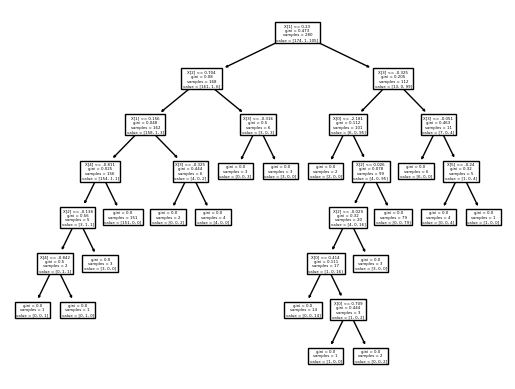

In [271]:
plot_tree(dt)


In [278]:
dt_best = DecisionTreeClassifier(
    random_state=0
    ) 
dt_best.fit(x, y)

DecisionTreeClassifier(random_state=0)

In [279]:
feature_importances = dt_best.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

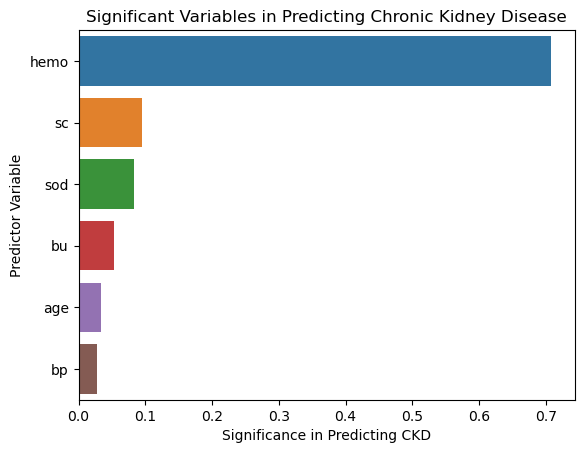

In [284]:
sns.barplot(x = sorted_importances, y = sorted_feature_names)
plt.ylabel("Predictor Variable")
plt.xlabel("Significance in Predicting CKD")
plt.title("Significant Variables in Predicting Chronic Kidney Disease")
plt.show()

Out of all the predictor variables, the most important/significant one in predicting chronic kidney disease is hemoglobin. We also saw earlier, in part 4, how strongly this variable is associated with the other variables of the original dataset.